In [1]:
import torch
from typing import Sequence, Literal, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd

def add_gaussian_noise_xy(  # name kept for drop-in; now supports L-shape with smoothing
    xy: torch.Tensor,                 # (N, 2)
    u: torch.Tensor,                  # (N, 1) or (N,)
    *,
    centers: Sequence[Sequence[float]],
    radii: float | Sequence[float] | Sequence[Sequence[float]],
    sigmas: float | Sequence[float],
    base_sigma: float = 0.0,          # background noise std
    index_eps: float = 1e-6,          # threshold above background to count as "modified"
    generator: torch.Generator | None = None,
    clamp: tuple[float, float] | None = None,
    return_sigma: bool = False,
    combine: Literal["sum", "max", "quadrature"] = "sum",
    edge_tau: float = 0.05,           # softness of boundary: normalized (islands) or absolute (L-shape)
    # ===== NEW: optional L-shape region =====
    l_shape: Optional[Dict[str, object]] = None,
):
    """
    Adds heteroscedastic noise with smoothed regions:

    1) Soft-step *islands* (circles/ellipses):
        For each center c_k with radius r_k (or ellipse (rx, ry)),
        smooth indicator:
            w_k(x) = sigmoid( (1 - d_k(x)) / edge_tau ),
            d_k(x) = sqrt( ((x - c_k)/r_k)^T ((x - c_k)/r_k) )
        Aggregation across islands uses `combine`:
            - "sum"        : sigma = base_sigma + sum_k S_k * w_k
            - "max"        : sigma = base_sigma + max_k (S_k * w_k)
            - "quadrature" : sigma = sqrt(base_sigma^2 + sum_k (S_k^2 * w_k^2))
        Here, `edge_tau` is in *normalized radial units*.

    2) NEW: Smoothed *L-shape* (union of two perpendicular rectangles, axis-aligned):
        Provide `l_shape` dict with keys:
            - corner: (cx, cy)  -> the *inner* corner where arms meet
            - lengths: (Lx, Ly) -> arm lengths along +/−x and +/−y
            - thickness: float  -> common arm width
            - orientation: one of {"NE","NW","SE","SW"} (default "NE")
            - sigma: optional float amplitude for this region (falls back to `sigmas` scalar or first elem)
        Smooth indicator is:
            w_L(x) = sigmoid( - sdf_L(x) / edge_tau ),
        where sdf_L is the signed distance to the *union* of the two rectangles
        (negative inside, positive outside). For the L-shape, `edge_tau` is in the
        *same coordinate units* as `xy` (absolute, not normalized).

    Returns:
        (u_noisy, idx)                 OR
        (u_noisy, sigma, idx)          if return_sigma=True
      - u_noisy: (N, 1)
      - sigma:   (N, 1) (only if return_sigma=True)
      - idx:     1D LongTensor where (sigma - base_sigma) > index_eps
    """
    # --- shape checks / normalize ---
    if xy.ndim != 2 or xy.shape[1] != 2:
        raise ValueError("xy must have shape (N, 2)")
    u = u.reshape(-1, 1)
    if xy.shape[0] != u.shape[0]:
        raise ValueError("xy and u must have the same number of points (N)")

    device, dtype = u.device, u.dtype
    XY = xy.to(device=device, dtype=dtype)

    # Utility: rectangle signed distance function for axis-aligned box [x0, x1] × [y0, y1]
    def _sdf_rect(xy_: torch.Tensor, x0, x1, y0, y1) -> torch.Tensor:
        x = xy_[:, 0]
        y = xy_[:, 1]
        # Outside distances along each axis (0 if inside along that axis)
        dx_out = torch.maximum(x0 - x, x - x1).clamp_min(0)
        dy_out = torch.maximum(y0 - y, y - y1).clamp_min(0)
        outside_dist = torch.sqrt(dx_out * dx_out + dy_out * dy_out)

        # Inside => negative distance = -min distance to an edge
        inside_mask = (x >= x0) & (x <= x1) & (y >= y0) & (y <= y1)
        dist_to_edges = torch.minimum(torch.minimum(x - x0, x1 - x),
                                      torch.minimum(y - y0, y1 - y))
        inside_dist = -dist_to_edges
        return torch.where(inside_mask, inside_dist, outside_dist)

    # Build a list of (weights, amplitudes) from islands and/or L-shape
    W_list = []
    S_list = []

    # -------- Islands (original behavior) --------
    C = torch.as_tensor(centers, dtype=dtype, device=device).reshape(-1, 2)  # (K,2)
    K = C.shape[0]

    if K > 0:
        # amplitudes per island
        S_islands = (torch.full((K,), float(sigmas), dtype=dtype, device=device)
                     if isinstance(sigmas, (int, float))
                     else torch.as_tensor(sigmas, dtype=dtype, device=device).reshape(-1))
        if S_islands.numel() != K:
            raise ValueError("For islands, sigmas must be scalar or length == len(centers)")

        # radii: scalar, (K,), or (K,2)
        R_raw = torch.as_tensor(radii, dtype=dtype, device=device)
        if R_raw.ndim == 0:
            R_iso = R_raw.expand(K)    # isotropic radius shared by all
            R_aniso = None
        elif R_raw.ndim == 1:
            if R_raw.numel() != K:
                raise ValueError("radii 1D must have length == len(centers)")
            R_iso = R_raw
            R_aniso = None
        elif R_raw.ndim == 2 and R_raw.shape == (K, 2):
            R_iso = None
            R_aniso = R_raw
        else:
            raise ValueError("radii must be scalar, length-K, or shape (K,2) for anisotropic")

        # compute normalized distance and soft weights
        diff = XY[:, None, :] - C[None, :, :]          # (N,K,2)
        tiny = torch.finfo(dtype).tiny
        if R_aniso is None:
            R2 = (R_iso.clamp_min(tiny)) ** 2          # (K,)
            Q  = (diff.pow(2).sum(dim=2)) / R2[None, :]   # (N,K)
        else:
            R2 = (R_aniso.clamp_min(tiny)) ** 2        # (K,2)
            Q  = (diff.pow(2) / R2[None, :, :]).sum(dim=2)  # (N,K)

        d_norm = Q.clamp_min(0).sqrt()                 # normalized radial distance
        tau_norm = max(float(edge_tau), 1e-12)
        w_islands = torch.sigmoid((1.0 - d_norm) / tau_norm).to(dtype)  # (N,K)
        W_list.append(w_islands)
        S_list.append(S_islands)

    # -------- L-shape (NEW) --------
    if l_shape is not None:
        # Parse parameters
        corner: Tuple[float, float] = tuple(l_shape.get("corner", (0.5, 0.5)))  # inner corner where arms meet
        lengths: Tuple[float, float] = tuple(l_shape.get("lengths", (0.5, 0.5)))  # (Lx, Ly)
        thickness: float = float(l_shape.get("thickness", 0.2))
        orientation: str = str(l_shape.get("orientation", "NE")).upper()
        # Amplitude for L-shape (falls back to scalar sigmas or first element)
        if "sigma" in l_shape:
            S_L_val = float(l_shape["sigma"])
        else:
            if isinstance(sigmas, (int, float)):
                S_L_val = float(sigmas)
            else:
                S_L_val = float(torch.as_tensor(sigmas, dtype=dtype).reshape(-1)[0].item())

        cx, cy = corner
        Lx, Ly = lengths
        t = thickness
        if t <= 0 or Lx <= 0 or Ly <= 0:
            raise ValueError("l_shape: thickness and lengths must be positive.")

        # Build rectangles H (horizontal arm) and V (vertical arm) from orientation
        if orientation == "NE":
            x0_h, x1_h, y0_h, y1_h = cx, cx + Lx, cy, cy + t
            x0_v, x1_v, y0_v, y1_v = cx, cx + t,  cy, cy + Ly
        elif orientation == "NW":
            x0_h, x1_h, y0_h, y1_h = cx - Lx, cx, cy, cy + t
            x0_v, x1_v, y0_v, y1_v = cx - t,  cx,  cy, cy + Ly
        elif orientation == "SE":
            x0_h, x1_h, y0_h, y1_h = cx, cx + Lx, cy - t, cy
            x0_v, x1_v, y0_v, y1_v = cx, cx + t,  cy - Ly, cy
        elif orientation == "SW":
            x0_h, x1_h, y0_h, y1_h = cx - Lx, cx, cy - t, cy
            x0_v, x1_v, y0_v, y1_v = cx - t,  cx,  cy - Ly, cy
        else:
            raise ValueError("l_shape['orientation'] must be one of {'NE','NW','SE','SW'}.")

        # Signed distance to union of rectangles = min(sdf(H), sdf(V))
        sdf_h = _sdf_rect(XY, x0_h, x1_h, y0_h, y1_h)
        sdf_v = _sdf_rect(XY, x0_v, x1_v, y0_v, y1_v)
        sdf_L = torch.minimum(sdf_h, sdf_v)

        tau_abs = max(float(edge_tau), 1e-12)  # absolute units for L-shape
        w_L = torch.sigmoid(-sdf_L / tau_abs).to(dtype).unsqueeze(1)  # (N,1)
        W_list.append(w_L)
        S_list.append(torch.as_tensor([S_L_val], dtype=dtype, device=device))

    # If neither islands nor L-shape were provided -> background only
    if len(W_list) == 0:
        sigma = torch.full_like(u, float(base_sigma))
        noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
        u_noisy = u + noise
        if clamp is not None:
            lo, hi = clamp
            u_noisy = u_noisy.clamp(min=lo, max=hi)
        idx = torch.zeros(0, dtype=torch.long, device=device)
        return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)

    # Concatenate all contributions and aggregate by rule
    W = torch.cat(W_list, dim=1)                     # (N, M)
    S_all = torch.cat([s.reshape(-1) for s in S_list])  # (M,)

    if combine == "sum":
        add = W * S_all[None, :]                     # (N, M)
        sigma = add.sum(dim=1, keepdim=True) + float(base_sigma)
    elif combine == "max":
        add = W * S_all[None, :]
        sigma = add.max(dim=1, keepdim=True).values + float(base_sigma)
    elif combine == "quadrature":
        add = (W * S_all[None, :]) ** 2
        sigma = (add.sum(dim=1, keepdim=True) + float(base_sigma) ** 2).sqrt()
    else:
        raise ValueError("combine must be one of: 'sum', 'max', 'quadrature'")

    sigma = sigma.clamp_min(0)

    # indices where contribution above background
    idx = torch.nonzero((sigma.view(-1) - float(base_sigma)) > float(index_eps),
                        as_tuple=False).squeeze(1)

    # Sample and add noise
    noise = torch.normal(mean=torch.zeros_like(u), std=sigma, generator=generator)
    u_noisy = u + noise
    if clamp is not None:
        lo, hi = clamp
        u_noisy = u_noisy.clamp(min=lo, max=hi)

    return (u_noisy, sigma, idx) if return_sigma else (u_noisy, idx)


In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
# torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D
from utils_tools.utils_tuning import save_plot

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
seed = 7
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 250  # Number of collocation points

data_noise = 0.05
N_train = 300
N_test = 1000 # 2000
N_calib = 100
N_valid = 200

N_total= N_train+N_test+N_calib

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)

X_vis, Y_vis = pde.data_generation(N_total, data_noise)
# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(n=20, step=0.05)

alpha = 0.05

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()



# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 200
g  = torch.Generator().manual_seed(seed)

# Define printing grid
grid_test, u = pde.solution_field_on_grid(n_grid, source="true", flatten=True)
u_noisy, sigma, id_grid = add_gaussian_noise_xy(
    grid_test, u,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.4],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.3),
    edge_tau=0.1
)

Y_train_clean = Y_train.clone()
Y_test_clean  = Y_test.clone()
Y_cal_clean   = Y_calibration.clone()

Y_train, sigma_train, id_train = add_gaussian_noise_xy(
    X_train, Y_train_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.4],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.3),
    edge_tau=0.1
)
Y_test, sigma_test, id_test = add_gaussian_noise_xy(
    X_test, Y_test_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.4],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.3),
    edge_tau=0.1
)
Y_calibration, sigma_calibration, id_calibration = add_gaussian_noise_xy(
    X_calibration, Y_cal_clean,
    centers=[(-0.5, -0.5)], radii=0.3, sigmas=[0.4],
    base_sigma=0.00, combine="quadrature",
    return_sigma=True,
    l_shape=dict(corner=(0.3, 0.3), lengths=(0.6, 0.6), thickness=0.1, orientation="NE", sigma=0.3),
    edge_tau=0.1
)


save_plot(
    plot_truth_and_samples_2D,
    save_dir="2D_AllenCahn", prefix="2D_AllenCahn_data",
)(
    X_test, Y_test, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


<Figure size 640x480 with 0 Axes>

# Change make the noise sharper and larger, currently too few sample are considered as out of CP interval.

# Try step-wise disc noise added.

# Step wise noise

In [3]:

import torch
from typing import Sequence, Literal
import matplotlib.pyplot as plt
import pandas as pd

def plot_metrics_table(
    X_test: torch.Tensor,
    cp_uncal_predset,
    cp_cal_predset,
    true_solution,
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df1_name: str="Uncalibrated",
    df2_name: str="Calibrated",
    title: str = "",
    main_title: str | None = None,
    X_vis=None, Y_vis=None,
    alpha_level: float = 0.05,
    figsize: tuple = (9, 2.5),
    max_digits_display = lambda x: f"{x:.4g}"
):
    """
    Display a side-by-side metrics comparison (table) for the uncalibrated and
    calibrated models at a single alpha level.
    """
    # Compute the coverage deviation using mae
    def prepare_coverage_data(df):
        expected = 1 - df["alpha"]
        empirical = df["coverage"]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sort_idx = exp_full.argsort()
        exp_sorted, emp_sorted = exp_full[sort_idx], emp_full[sort_idx]
        return exp_sorted.to_numpy(), emp_sorted.to_numpy()

    def coverage_deviation(exp, emp, how="mae"):
        diff = np.abs(emp - exp)
        if   how == "mae":  return diff.mean()
        elif how == "rmse": return np.sqrt((diff**2).mean())
        elif how == "max":  return diff.max()
        else:
            raise ValueError("metric must be 'mae', 'rmse', or 'max'")

    exp1, emp1 = prepare_coverage_data(df1)
    exp2, emp2 = prepare_coverage_data(df2)
    dev1 = coverage_deviation(exp1, emp1)  # Using the default metrics
    dev2 = coverage_deviation(exp2, emp2)  # Using the default metrics
    print(f"Uncal dev:{dev1}")
    print(f"Cal dev:{dev2}")
    alpha_level_upper = alpha_level + 1e-3
    alpha_level_lower = alpha_level - 1e-3
    
    # ────────────────────── 1. Slice the two rows ──────────────────────
    row_uncal = df1.loc[(df1["alpha"] <= alpha_level_upper) & 
                           (df1["alpha"] >= alpha_level_lower)].copy()
    row_uncal["model"] = df1_name
    row_uncal["expected coverage"] = (1 - row_uncal["alpha"])
    row_uncal["mean coverage deviation"] = "{:.4f}".format(dev1)
    row_uncal["coverage"] = (row_uncal["coverage"]).map("{:.2f}".format)

    row_cal = df2.loc[(df2["alpha"] <= alpha_level_upper) & 
                        (df2["alpha"] >= alpha_level_lower)].copy()
    row_cal["model"] = df2_name
    row_cal["expected coverage"] = (1- row_cal["alpha"])
    row_cal["mean coverage deviation"] = "{:.4f}".format(dev2)
    row_cal["coverage"] = (row_cal["coverage"]).map("{:.2f}".format)

    if row_uncal.empty or row_cal.empty:
        raise ValueError(f"alpha={alpha_level} not found in both data frames.")

    # ───────────────────── 2. Stack & tidy up ──────────────────────────
    rows = pd.concat([row_uncal, row_cal], axis=0).reset_index(drop=True)
    rows = rows.rename(columns={"coverage": "actual coverage"})
    # Get all columns except 'model' for the selection
    other_cols = [c for c in rows.columns if c != "model"]
    rows = rows.loc[:, ["model"] + other_cols]

    
    # nice ordering: model | expected alpha | true alpha | <metrics…>
    metric_cols = [c for c in rows.columns if c not in ("model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness")]
    rows = rows[["model", "expected coverage", "actual coverage", "mean coverage deviation", "sharpness"]]
    

    # ──────────────── 2.5. Format numeric values ───────────────────────
    # Format all numeric columns to 4 decimal places (excluding 'model' column)
    for col in rows.columns:
        if pd.api.types.is_numeric_dtype(rows[col]):
            rows[col] = rows[col].apply(max_digits_display)  # .4g gives up to 4 significant 

    # ───────────────────── 3. Plot as table ────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    table = ax.table(
        cellText=rows.values,
        colLabels=rows.columns,
        loc="center",
        cellLoc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.25)

    if main_title is not None:
        plt.title(main_title, pad=20, fontsize=12)

    plt.tight_layout()


x-range: -1.0 1.0
y-range: -1.0 1.0


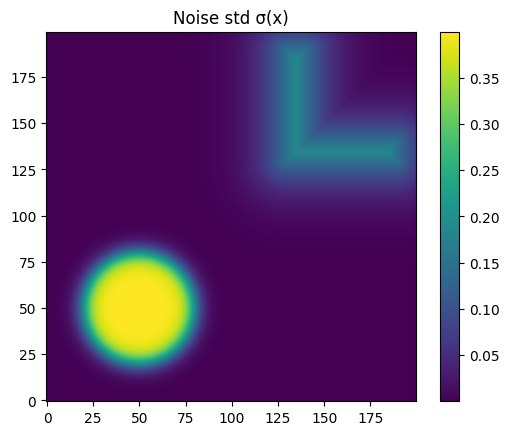

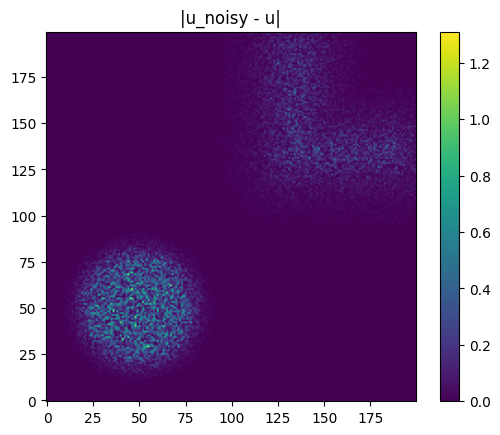

In [4]:
# 1) Make sure both centers lie in your domain
print("x-range:", grid_test[:,0].min().item(), grid_test[:,0].max().item())
print("y-range:", grid_test[:,1].min().item(), grid_test[:,1].max().item())
# If your domain isn’t ~[0,1]×[0,1], adjust centers/radii accordingly.

# 2) Visualize the heteroscedasticity itself
n = int((grid_test.shape[0])**0.5)
Sigma_grid = sigma.view(n, n)
plt.imshow(Sigma_grid.cpu(), origin="lower")     # or cmap="magma"
plt.title("Noise std σ(x)")
plt.colorbar()

# 3) Alternatively, look at absolute error from a single draw
err = (u_noisy - u).abs().view(n, n)
plt.figure(); plt.imshow(err.cpu(), origin="lower"); plt.title("|u_noisy - u|"); plt.colorbar()


# Training

In [5]:
import matplotlib.colors as mcolors
# Define color map
colors = ["#2989ff","#ffffff", "#ff424f"]
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

colors = ["#8c52ff","#ffffff", "#ff66c4"]
my_cmap_2 = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

def plot_uq_field(
    XY_grid: torch.Tensor,
    true_solution,                 # callable: (N,2) torch -> (N,) or (N,1)
    pred_set=None,                 # tuple(lower, upper) torch tensors (optional if mode='true')
    *,
    mode: str = "mean",            # 'true' | 'mean' | 'width' | 'diff'
    grid_shape=None,               # (H, W); if None, inferred as square
    extent=None,                   # [xmin, xmax, ymin, ymax]; if None, inferred from XY_grid
    vlim=None,                     # (vmin, vmax) or None
    scatter=None,                  # (x_pts, y_pts) numpy arrays or None
    cmap=my_cmap,
    figsize=(6, 5),
    colorbar_label=None,
    cbar_kwargs=None,              # dict passed to fig.colorbar
    norm=None,                     # matplotlib.colors.Normalize (overrides vlim)
    title="",

    # --- NEW: style alignment with coverage plot ---
    ax=None,                       # draw on provided axes
    cax=None,                      # colorbar axis (optional)
    add_colorbar=True,             # toggle colorbar
    n_ticks: int = 9,              # number of major ticks on x/y
    font_size: int = 12,           # label/title font size
    tick_size: int = 10,           # tick label size
    grid_alpha: float = 0.2,       # grid transparency
    box_aspect: float = 1.0,       # square plotting box like imshow panels
    match_to_ax=None,              # Axes whose box size (inches) we want to match
):
    """
    Plot a single 2D field and (optionally) match the *axes box size* to another Axes
    (e.g., the coverage plot), so the panels are visually identical in size and tick scale.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    # ---- infer grid shape ----
    N = XY_grid.shape[0]
    if grid_shape is None:
        side = int(round(np.sqrt(N)))
        if side * side != N:
            raise ValueError(
                "grid_shape not provided and XY_grid is not square-lengthed; "
                f"N={N} cannot form H×W with H=W."
            )
        H = W = side
    else:
        H, W = grid_shape
        if H * W != N:
            raise ValueError(f"grid_shape {grid_shape} incompatible with XY_grid length {N}.")

    # ---- extent from XY_grid if needed ----
    x = XY_grid[:, 0].detach().cpu().numpy()
    y = XY_grid[:, 1].detach().cpu().numpy()
    if extent is None:
        extent = [float(x.min()), float(x.max()), float(y.min()), float(y.max())]

    # ---- build the field to plot ----
    mode = mode.lower()
    if mode == "true":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        field = z.reshape(H, W)
        default_label = "u(x, y)"
    elif mode in ("mean", "width"):
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'mean' or 'width'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        if mode == "mean":
            field = ((lower + upper) / 2.0).reshape(H, W)
            default_label = "Predictive mean"
        else:  # 'width'
            field = (upper - lower).reshape(H, W)
            default_label = "Interval width"
    elif mode == "diff":
        with torch.no_grad():
            z = true_solution(XY_grid).detach().cpu().numpy().reshape(-1)
        true_field = z.reshape(H, W)
        if pred_set is None or len(pred_set) != 2:
            raise ValueError("pred_set=(lower, upper) is required for mode 'diff'.")
        lower = pred_set[0].detach().cpu().numpy().reshape(-1)
        upper = pred_set[1].detach().cpu().numpy().reshape(-1)
        pred_field = ((lower + upper) / 2.0).reshape(H, W)
        field = np.abs(pred_field - true_field)
        default_label = "Error"
    else:
        raise ValueError("mode must be 'true', 'mean', 'diff', or 'width'.")

    # ---- create fig/axes (optionally with a dedicated cbar axis) ----
    if ax is None:
        if add_colorbar and cax is None:
            # Make a 1x2 GridSpec so the colorbar column doesn't squeeze the plot area.
            fig = plt.figure(figsize=figsize, constrained_layout=False)
            gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.045], wspace=0.15)
            ax = fig.add_subplot(gs[0, 0])
            cax = fig.add_subplot(gs[0, 1])  # skinny colorbar axis
        else:
            fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # ---- imshow ----
    imshow_kwargs = dict(
        extent=extent,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        cmap=cmap,
    )
    if norm is not None:
        imshow_kwargs["norm"] = norm
    elif vlim is not None:
        imshow_kwargs["vmin"], imshow_kwargs["vmax"] = vlim

    im = ax.imshow(field, **imshow_kwargs)

    # ---- style to match coverage plot ----
    ax.set_xlabel("x", fontsize=font_size)
    ax.set_ylabel("y", fontsize=font_size)
    ax.set_title(title, fontsize=font_size)
    ax.tick_params(axis='both', labelsize=tick_size)

    # square box like your coverage panel (so both look consistent)
    try:
        ax.set_box_aspect(box_aspect)
    except Exception:
        pass

    # ticks: make the count match (the *number* of grid lines)
    ax.xaxis.set_major_locator(LinearLocator(n_ticks))
    ax.yaxis.set_major_locator(LinearLocator(n_ticks))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # ---- colorbar (optionally in the provided cax) ----
    if add_colorbar:
        cbar = fig.colorbar(im, cax=cax if cax is not None else None,
                            ax=None if cax is not None else ax,
                            **(cbar_kwargs or {}))
        if not (cbar_kwargs and ("label" in cbar_kwargs)):
            cbar.set_label(colorbar_label or default_label)

    # ---- (optional) match the axes *box size* to another Axes (e.g., coverage) ----
    if match_to_ax is not None:
        # target size in inches
        fig.canvas.draw()
        target_box = match_to_ax.get_window_extent().transformed(
            match_to_ax.figure.dpi_scale_trans.inverted()
        )
        target_w, target_h = target_box.width, target_box.height

        # current size
        curr_box = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        curr_w, curr_h = curr_box.width, curr_box.height

        # scale figure so ax box matches target
        if curr_w > 0 and curr_h > 0:
            fw, fh = fig.get_size_inches()
            sx, sy = (target_w / curr_w), (target_h / curr_h)
            fig.set_size_inches(fw * sx, fh * sy, forward=True)
            fig.canvas.draw()  # re-layout once after resizing

    fig.tight_layout()
    return fig, ax, field


# Feature Distance model

In [6]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}
raw_heuristic = "feature"
# CP-Model
k=40
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":raw_heuristic,
    "n_samples":k
}

dist_feat_pinn = DistanceUQPINN(**model_args)

In [7]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=4500,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=k,
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.32e+00 | lr=1.0e-03
ep   500 | L=5.58e-02 | lr=1.0e-03
ep  1000 | L=2.72e-02 | lr=1.0e-03
ep  1500 | L=2.25e-02 | lr=1.0e-03
ep  2000 | L=1.85e-02 | lr=1.0e-03
ep  2500 | L=1.66e-02 | lr=1.0e-03
ep  3000 | L=3.00e-02 | lr=1.0e-03
ep  3500 | L=2.70e-02 | lr=1.0e-03
ep  4000 | L=1.44e-02 | lr=1.0e-03
ep  4500 | L=1.50e-02 | lr=1.0e-03


In [8]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

# CP

In [9]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":k
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

# Local CP

In [10]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


# Plot the results

In [11]:
def plot_2D_comparison_with_coverage_error_compare(
    XY_test,
    error,
    pred_set_uncal,
    pred_set_cp,
    pred_set_local_cp,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    X_vis=None, Y_vis=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage',
    metric: str = "mae",
    main_title=None,
    grid_size=200,
    *,
    row1_vlim=None,
    row2_vlim=None,
    labels=("After CP", "After Local CP"),
    # layout knobs
    middle_col_width=0.03,
    coverage_col_width=1.5,
    wspace=-0.13,                  # legacy: global inter-column spacing
    wspaces=(0.115, 0.02, 0.35),   # NEW: tuple (w01, w12, w23) for per-interval gaps
    hspace=0.15,
    cb_tick_pad=6,
    cb_tick_size=10,
    width_cmap=my_cmap_2,
    # ===== NEW: grid controls =====
    field_grid=True,                # show grids on the 4 field plots
    field_grid_which="both",        # "major" | "minor" | "both"
    field_grid_color="0.5",
    field_grid_alpha=0.0,
    field_grid_ls=":",
    field_grid_lw=0.6,
    x_major_step=0.35, y_major_step=0.35,
    x_minor_step=0.35, y_minor_step=0.35,
    field_grid_on_top=False,
    # Optional grid on coverage plot
    coverage_grid=True,
    cov_x_major_step=0.2, cov_y_major_step=0.2,
    cov_x_minor_step=0.2, cov_y_minor_step=0.2,
    coverage_grid_which="both",
    title_fontsize = 18,
    fs_cov = 19, 
    fs_fp = 16,
    f_label = "Local\n$x \in \{x:c=(0,0), r=0.2\}$"
):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import pandas as pd
    import matplotlib.colors as mcolors
    from matplotlib.cm import ScalarMappable, get_cmap
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    # ---------- helpers ----------
    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return t

    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        exp_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        emp_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        idx = np.argsort(exp_full.values)
        return exp_full.values[idx], emp_full.values[idx]

    # apply grid styling to an axes
    def _apply_grid(ax, *, which, color, alpha, ls, lw,
                    xmaj, ymaj, xmin, ymin, on_top):
        if xmaj is not None: ax.xaxis.set_major_locator(MultipleLocator(xmaj))
        if ymaj is not None: ax.yaxis.set_major_locator(MultipleLocator(ymaj))
        if xmin is not None: ax.xaxis.set_minor_locator(MultipleLocator(xmin))
        elif which in ("minor", "both"): ax.xaxis.set_minor_locator(AutoMinorLocator())
        if ymin is not None: ax.yaxis.set_minor_locator(MultipleLocator(ymin))
        elif which in ("minor", "both"): ax.yaxis.set_minor_locator(AutoMinorLocator())

        ax.grid(True, which=which, color=color, alpha=alpha, linestyle=ls, linewidth=lw)
        ax.set_axisbelow(not on_top)
        if on_top:
            for ln in ax.get_xgridlines() + ax.get_ygridlines():
                ln.set_zorder(3)

    def _scatter_to_grid(vals_scatter, XY_scatter, Xg, Yg):
        """Nearest-neighbor map from scatter (N,) onto grid (G=grid_size^2)->(grid_size,grid_size)."""
        XYs = to_numpy(XY_scatter).reshape(-1, 2)
        v   = to_numpy(vals_scatter).reshape(-1)
        P   = np.stack([Xg.ravel(), Yg.ravel()], axis=1)        # (G,2)
        d2  = ((P[:, None, :] - XYs[None, :, :]) ** 2).sum(axis=2)
        idx = d2.argmin(axis=1)
        return v[idx].reshape(grid_size, grid_size)

    # optional points
    if show_pts:
        if X_vis is not None and Y_vis is not None:
            x_pts = to_numpy(X_vis).flatten(); y_pts = to_numpy(Y_vis).flatten()
        elif X_pts is not None:
            X_pts_np = to_numpy(X_pts); x_pts, y_pts = X_pts_np[:, 0], X_pts_np[:, 1]
        else:
            x_pts = y_pts = None
    else:
        x_pts = y_pts = None

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    # ---------- grid + fields ----------
    x = to_numpy(XY_test[:, 0]); y = to_numpy(XY_test[:, 1])
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    torch_dtype = XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32
    XY_grid = torch.tensor(np.stack([X_grid.ravel(), Y_grid.ravel()], axis=1), dtype=torch_dtype)

    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).ravel()
        upper = to_numpy(pred_set[1]).ravel()
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal, width_uncal = prep_interval(pred_set_uncal)
    mean_cp_cal,   width_cp_cal   = prep_interval(pred_set_cp)
    mean_local_cp_cal, width_local_cp_cal = prep_interval(pred_set_local_cp)
    pred_mean = mean_uncal

    # ---------- shared vlims ----------
    if row1_vlim is None:
        r1_min = min(true_grid.min(), pred_mean.min())
        r1_max = max(true_grid.max(), pred_mean.max())
        if vlim_true is not None:
            r1_min = min(r1_min, float(vlim_true[0])); r1_max = max(r1_max, float(vlim_true[1]))
        if vlim_pred_mean is not None:
            r1_min = min(r1_min, float(vlim_pred_mean[0])); r1_max = max(r1_max, float(vlim_pred_mean[1]))
        row1_vlim = (r1_min, r1_max)

    if row2_vlim is None:
        if vlim_pred_width is not None:
            row2_vlim = (float(vlim_pred_width[0]), float(vlim_pred_width[1]))
        else:
            row2_vlim = (min(width_uncal.min(), width_cal.min()),
                         max(width_uncal.max(), width_cal.max()))

    G = grid_size * grid_size
    # --- error grid (independent of row2_vlim; safe defaults) ---
    if error is None:
        err_grid = np.abs(pred_mean - true_grid)
    else:
        err_np = to_numpy(error).reshape(-1)
        if err_np.size == G:
            err_grid = err_np.reshape(grid_size, grid_size)
        elif err_np.size == len(to_numpy(XY_test)):
            err_grid = _scatter_to_grid(err_np, XY_test, X_grid, Y_grid)
        else:
            raise ValueError(
                "error length does not match grid_size^2 or len(XY_test). "
                "Provide a gridded error of shape (grid_size, grid_size) or a vector "
                f"of length {G} or {len(to_numpy(XY_test))}."
            )
    e_min, e_max = float(np.nanmin(err_grid)), float(np.nanmax(err_grid))
    if not np.isfinite(e_min) or not np.isfinite(e_max) or e_min == e_max:
        e_min, e_max = 0.0, 1.0
    err_vlim = (e_min, e_max)

    extent = [x.min(), x.max(), y.min(), y.max()]
    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)

    # ---------- figure + layout ----------
    fig = plt.figure(figsize=(22, 10))

    use_custom_wspaces = (wspaces is not None)
    if use_custom_wspaces:
        if not (isinstance(wspaces, (list, tuple)) and len(wspaces) == 3):
            raise ValueError("wspaces must be a 3-tuple/list: (gap_0_1, gap_1_2, gap_2_3).")
        gap01 = max(float(wspaces[0]), 0.0)
        gap12 = max(float(wspaces[1]), 0.0)
        gap23 = max(float(wspaces[2]), 0.0)

        width_ratios = [1.0, gap01, middle_col_width, gap12, 1.0, gap23, coverage_col_width]
        gs = fig.add_gridspec(
            2, 7,
            width_ratios=width_ratios,
            wspace=0.0,
            hspace=hspace
        )
        col = {"imgL":0, "gap01":1, "cbar":2, "gap12":3, "imgR":4, "gap23":5, "cov":6}
        ax_true = fig.add_subplot(gs[0, col["imgL"]])
        ax_err  = fig.add_subplot(gs[0, col["imgR"]])
        ax_wb   = fig.add_subplot(gs[1, col["imgL"]])
        ax_wa   = fig.add_subplot(gs[1, col["imgR"]])
        cax1 = fig.add_subplot(gs[0, col["cbar"]])
        cax2 = fig.add_subplot(gs[1, col["cbar"]])
        ax_cov = fig.add_subplot(gs[:, col["cov"]])
    else:
        gs = fig.add_gridspec(
            2, 4,
            width_ratios=[1, middle_col_width, 1, coverage_col_width],
            wspace=wspace,
            hspace=hspace
        )
        ax_true = fig.add_subplot(gs[0, 0])
        ax_err  = fig.add_subplot(gs[0, 2])
        ax_wb   = fig.add_subplot(gs[1, 0])
        ax_wa   = fig.add_subplot(gs[1, 2])
        cax1 = fig.add_subplot(gs[0, 1])
        cax2 = fig.add_subplot(gs[1, 1])
        ax_cov = fig.add_subplot(gs[:, 3])

    for ax in (ax_true, ax_err, ax_wb, ax_wa):
        ax.set_box_aspect(1)

    # colormaps
    cmap_row1 = my_cmap  # assumes provided externally
    cmap_row2 = get_cmap(width_cmap) if isinstance(width_cmap, str) else width_cmap

    # ----- Row 1: True, Error -----
    
    im_true = ax_true.imshow(
        err_grid, extent=extent, origin='lower',
        aspect='auto', interpolation='bilinear',
        vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row1
    )
    ax_true.set_title("True Error", fontsize=title_fontsize)
    ax_true.set_ylabel("y", fontsize=fs_fp)
    add_scatter(ax_true)
    ax_true.set_xticks([])
    ax_true.tick_params(bottom=False, labelbottom=False)
    
    # err_grid = np.log(err_grid)
    im_err = ax_err.imshow(
        width_uncal, extent=extent, origin='lower',
        aspect='auto', interpolation='bilinear',
        vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row1
    )
    ax_err.set_title("Before CP", fontsize=title_fontsize)
    add_scatter(ax_err)
    ax_err.set_xticks([]); ax_err.set_yticks([])
    ax_err.tick_params(which='both',
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    # ----- Row 2: Width Before, Width After -----
    # width_uncal = np.log(width_uncal)
    im_wb = ax_wb.imshow(
        width_cp_cal, extent=extent, origin='lower',
        aspect='auto', interpolation='bilinear',
        vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row1
    )
    ax_wb.set_title("After CP", fontsize=title_fontsize)
    ax_wb.set_xlabel("x", fontsize=fs_fp); ax_wb.set_ylabel("y", fontsize=fs_fp)
    add_scatter(ax_wb)

    # width_cal = np.log(width_cal)
    im_wa = ax_wa.imshow(
        width_local_cp_cal, extent=extent, origin='lower',
        aspect='auto', interpolation='bilinear',
        vmin=row2_vlim[0], vmax=row2_vlim[1], cmap=cmap_row1
    )
    ax_wa.set_title("After Local CP", fontsize=title_fontsize)
    add_scatter(ax_wa)
    ax_wa.set_xlabel("x", fontsize=fs_fp)
    ax_wa.set_yticks([])
    ax_wa.tick_params(which='both', left=False, right=False, labelleft=False)

    # ---- Colorbars in middle column (ticks on LEFT; NO labels) ----
    sm1 = ScalarMappable(norm=mcolors.Normalize(vmin=row2_vlim[0], vmax=row2_vlim[1]), cmap=cmap_row1); sm1.set_array([])
    cbar1 = fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar1.ax.yaxis.set_ticks_position('left'); cbar1.ax.set_ylabel('')

    sm2 = ScalarMappable(norm=mcolors.Normalize(vmin=row2_vlim[0], vmax=row2_vlim[1]), cmap=cmap_row1); sm2.set_array([])
    cbar2 = fig.colorbar(sm2, cax=cax2)
    cbar2.ax.tick_params(labelsize=cb_tick_size, pad=cb_tick_pad)
    cbar2.ax.yaxis.set_ticks_position('left'); cbar2.ax.set_ylabel('')

    # ---- Coverage plot ----
    ax_cov.plot(exp1, emp1, marker='o', linestyle='-', color="#3245b1",
                markerfacecolor="#6988ef", ms=13, lw=5, label=f'{labels[0]}')
    ax_cov.plot(exp2, emp2, marker='*', linestyle='-', color="#b13c32",
                markerfacecolor="#ed8076", ms=20, lw=5, label=f'{labels[1]}')
    ax_cov.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    ax_cov.autoscale(enable=True, tight=False)
    ax_cov.margins(x=0.03, y=0.03)
    ax_cov.set_aspect('equal', adjustable='box')
    ax_cov.set_xlabel("Expected Coverage (1 − α)",  fontsize=fs_cov)
    ax_cov.set_ylabel("Empirical Coverage",         fontsize=fs_cov)
    if coverage_grid:
        _apply_grid(ax_cov, which=coverage_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                    ls=field_grid_ls, lw=field_grid_lw, on_top=False,
                    xmaj=cov_x_major_step, ymaj=cov_y_major_step,
                    xmin=cov_x_minor_step, ymin=cov_y_minor_step)
    ax_cov.legend(loc='lower right', fontsize=18)
    ax_cov.text(
            0.02, 0.98, f_label,
            transform=ax_cov.transAxes,
            fontsize=25, 
            fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # ---- Apply grid to the four field plots (if requested) ----
    if field_grid:
        for ax in (ax_true, ax_err, ax_wb, ax_wa):
            _apply_grid(ax, which=field_grid_which, color=field_grid_color, alpha=field_grid_alpha,
                        ls=field_grid_ls, lw=field_grid_lw, on_top=field_grid_on_top,
                        xmaj=x_major_step, ymaj=y_major_step,
                        xmin=x_minor_step, ymin=y_minor_step)

    if main_title:
        fig.suptitle(main_title, fontsize=title_fontsize+2)

    axs = np.array([[ax_true, ax_err], [ax_wb, ax_wa]])
    return fig, axs


In [12]:
import torch
from math import inf

@torch.no_grad()
def estimate_true_error_local_max(
    xy: torch.Tensor,          # (N, 2)
    u: torch.Tensor,           # (N, 1)  <-- use your observed y if you want data noise; don't pass model mean
    nghd_size,                 # float -> radius mode; int>=1 -> kNN mode
    *,
    include_self: bool = True,
    chunk_size: int = 4096,
) -> torch.Tensor:
    """
    For each point i, compute a local noise proxy:
        noise(i) = max_{j,k in N(i)} |u[j] - u[k]|
                  = (max_{j in N(i)} u[j]) - (min_{k in N(i)} u[k])

    Neighborhood N(i):
        - Radius mode (nghd_size: float): points with dist <= radius.
        - kNN mode    (nghd_size: int>=1): k nearest neighbors.

    Returns:
        (N,1) tensor of local ranges per point.

    Notes:
      • If you want "intrinsic data noise", pass your *observed* targets with noise as `u`.
      • Using ground-truth noiseless u will measure local function variability instead.
    """
    assert xy.ndim == 2 and xy.shape[1] == 2, "xy must be (N, 2)"
    assert u.ndim == 2 and u.shape[1] == 1, "u must be (N, 1)"
    N = xy.shape[0]
    device = xy.device
    u1 = u.squeeze(1)  # (N,)

    # ---------- kNN mode ----------
    if isinstance(nghd_size, int):
        assert nghd_size >= 1, "For kNN mode, nghd_size must be int>=1"
        k = min(nghd_size, N)
        row_block = max(1, chunk_size // 4)

        out = torch.empty((N,), device=device)
        for r0 in range(0, N, row_block):
            r1 = min(N, r0 + row_block)
            dists = torch.cdist(xy[r0:r1], xy)  # (r, N)

            if not include_self:
                for i in range(r0, r1):
                    dists[i - r0, i] = inf

            _, idx = torch.topk(dists, k=k, largest=False, dim=1)   # (r, k)
            neigh_u = u1[idx]                                       # (r, k)
            local_max = neigh_u.max(dim=1).values
            local_min = neigh_u.min(dim=1).values
            out[r0:r1] = (local_max - local_min)

        return out.unsqueeze(1)

    # ---------- radius mode ----------
    elif isinstance(nghd_size, float):
        radius = nghd_size
        assert radius > 0.0, "For radius mode, nghd_size must be a positive float"

        # Running extrema per row
        run_max = torch.full((N,), -inf, device=device)
        run_min = torch.full((N,),  inf, device=device)

        for c0 in range(0, N, chunk_size):
            c1 = min(N, c0 + chunk_size)
            dblock = torch.cdist(xy, xy[c0:c1])                     # (N, B)

            if not include_self:
                idx_rows = torch.arange(c0, c1, device=device)
                dblock[idx_rows, idx_rows - c0] = inf               # remove self

            mask = dblock <= radius                                 # (N, B)
            u_block = u1[c0:c1].unsqueeze(0).expand_as(dblock)      # (N, B)

            # masked maxima/minima in this block
            blk_max = torch.where(mask, u_block, torch.full_like(u_block, -inf)).max(dim=1).values
            blk_min = torch.where(mask, u_block, torch.full_like(u_block,  inf)).min(dim=1).values

            # update running extrema
            run_max = torch.maximum(run_max, blk_max)
            run_min = torch.minimum(run_min, blk_min)

        # Rows with no neighbors found (possible only if include_self=False and radius tiny)
        no_neigh = torch.isinf(run_max) | torch.isinf(run_min)
        if no_neigh.any():
            # define their range as 0 (or use self value to avoid NaNs)
            run_max[no_neigh] = u1[no_neigh]
            run_min[no_neigh] = u1[no_neigh]

        return (run_max - run_min).unsqueeze(1)

    else:
        raise ValueError("nghd_size must be int (kNN) or float (radius).")
    


def plot_coverage_grid_1x2_centered_legend(
    named_pairs,
    *,
    labels=("CP", "Local CP"),
    grid_figsize=(17, 7.5),
    suptitle=None,
    model_title_size=22,
    middle_ratio=0.35,   # adjust space for legend between plots
    float_labels=(("Local", "$x \in \{x:c=(0,0), r=0.2\}$"), ("Global", "$x \in \{(x,y): 0\leq x \leq 1 ,0\leq y \leq 1 \}$")),  # new floating labels
):
    """
    Plot 2 coverage plots side by side with the legend box
    placed directly in the middle between them. Each plot
    gets a floating text label at the upper-left corner.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    items = list(named_pairs.items()) if isinstance(named_pairs, dict) else list(named_pairs)
    if len(items) != 2:
        raise ValueError("Provide exactly 2 (name, df_uncal, df_cal) pairs.")

    # 1x3 layout: [plot1 | legend | plot2]
    fig, axs = plt.subplots(
        1, 3,
        figsize=grid_figsize,
        sharey=True,
        gridspec_kw={"width_ratios": [1.0, middle_ratio, 1.0]}
    )

    legend_handles, legend_labels = None, None

    # Left and right plots
    for ax_plot, (name, df_uncal, df_cal), flabel in zip([axs[0], axs[2]], items, float_labels):
        exp1, emp1 = _prep(df_uncal)
        exp2, emp2 = _prep(df_cal)

        ax_plot.plot(exp1, emp1, 'o-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=14, lw=5, label=labels[0])
        ax_plot.plot(exp2, emp2, '*-', color="#3291b1", markerfacecolor="#69b5ef",
                     ms=20, lw=5, label=labels[1])
        ax_plot.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

        if legend_handles is None:
            legend_handles, legend_labels = ax_plot.get_legend_handles_labels()

        ax_plot.set_xlabel("Expected Coverage (1 − α)", fontsize=18)
        ax_plot.autoscale(enable=True, tight=False)
        ax_plot.margins(x=0.02, y=0.02)
        ax_plot.set_title(name, fontsize=model_title_size)

        # floating label in upper-left corner
        ax_plot.text(
            0.02, 0.98, flabel[0],
            transform=ax_plot.transAxes,
            fontsize=25, 
            fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )
        ax_plot.text(
            0.02, 0.9, flabel[1],
            transform=ax_plot.transAxes,
            fontsize=20, 
            fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )
        

    axs[0].set_ylabel("Empirical Coverage", fontsize=18)

    # Middle subplot: legend only
    axs[1].axis("off")
    axs[1].legend(
        legend_handles, legend_labels,
        loc="lower center", frameon=True, fontsize=20, ncol=1
    )

    if suptitle:
        fig.suptitle(suptitle, fontsize=model_title_size + 2, y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.96])
    return fig, axs


In [13]:
err_est_noise = estimate_true_error_local_max(grid_test, u_noisy, nghd_size=8)

In [14]:
grid_test.shape

torch.Size([40000, 2])

In [15]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":4000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":7e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


/var/folders/nk/7m8bs7zj68dcqhl1g64gcwh80000gn/T/ipykernel_98598/2853600904.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


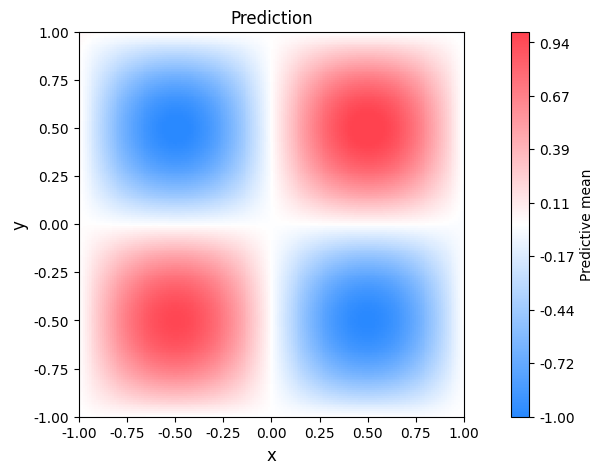

In [16]:
cbar_kwargs = {"ticks": np.linspace(-1.0, 1.5, 10), "format": "%.2f"}
vlim_mean = (-1.0, 1.0)
fig, ax, field = plot_uq_field(grid_test, pde.true_solution, dist_feat_pinn_cp_cal_predset, mode="mean",
                               vlim=vlim_mean, cbar_kwargs=cbar_kwargs, title="Prediction")


In [17]:
# CP Model (Adaptive)
from utils_extension.utils_uq_adapcp import AdaptiveCP_f, adaptive_cp_test_uncertainties_grid
training_kwargs={"step_size":5000, "gamma":0.5}
adap_kwarg={
    "alpha":alpha,
    "heuristic":raw_heuristic,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 128, 64, 64, 32, 16),
    "conf_nn_lr":1e-4,
    "conf_nn_epochs":30000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}

adap_cp = AdaptiveCP_f(dist_feat_pinn, **adap_kwarg)
adp_cp_cal_predset = adap_cp.predict(
    alpha=alpha, X_test=grid_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_calibration, Y_cal=Y_calibration, k=k
)


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


In [18]:
def plot_2D_comparison_with_coverage_error_compare(
    XY_test,
    error,
    pred_set_uncal,
    pred_set_cp,
    pred_set_local_cp,
    true_solution,
    *,
    grid_size=200,
    show_pts=False,
    X_pts=None,
    vlim=None,                # one shared vlim for ALL panels; auto if None
    cmap=my_cmap,           # one unique cmap for ALL panels
    title_fontsize=16,
    tick_labelsize=10,
    wspace=0.15,              # spacing between the 4 panels
):
    """
    4×1 panels (left→right): |ŷ - y|, width Before CP, width After CP, width After Local CP
    - Single shared colormap + single colorbar placed to the right of the entire row.
    - `vlim`: (vmin, vmax) shared across all panels; auto-computed from all fields if None.
    - `wspace`: horizontal spacing between panels.
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    def to_numpy(t):
        if isinstance(t, torch.Tensor):
            return t.detach().cpu().numpy()
        return np.asarray(t)

    def _scatter_to_grid(vals_scatter, XY_scatter, Xg, Yg):
        """Nearest-neighbor map from scatter (N,) onto (grid_size, grid_size)."""
        XYs = to_numpy(XY_scatter).reshape(-1, 2)
        v   = to_numpy(vals_scatter).reshape(-1)
        P   = np.stack([Xg.ravel(), Yg.ravel()], axis=1)  # (G,2)
        d2  = ((P[:, None, :] - XYs[None, :, :]) ** 2).sum(axis=2)
        idx = d2.argmin(axis=1)
        return v[idx].reshape(grid_size, grid_size)

    # ---- Build grid over XY_test bounds ----
    xy_np = to_numpy(XY_test)
    x_lin = np.linspace(xy_np[:,0].min(), xy_np[:,0].max(), grid_size)
    y_lin = np.linspace(xy_np[:,1].min(), xy_np[:,1].max(), grid_size)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(
        np.stack([Xg.ravel(), Yg.ravel()], axis=1),
        dtype=(XY_test.dtype if isinstance(XY_test, torch.Tensor) else torch.float32),
    )
    extent = [x_lin.min(), x_lin.max(), y_lin.min(), y_lin.max()]
    G = grid_size * grid_size

    # ---- True field on the grid ----
    true_grid = to_numpy(true_solution(XY_grid)).reshape(grid_size, grid_size)

    # ---- Intervals -> mean + width (reshaped to grid) ----
    def prep_interval(pred_set):
        lower = to_numpy(pred_set[0]).reshape(-1)
        upper = to_numpy(pred_set[1]).reshape(-1)
        mean  = (lower + upper) / 2.0
        width = upper - lower
        return mean.reshape(grid_size, grid_size), width.reshape(grid_size, grid_size)

    mean_uncal,    width_uncal    = prep_interval(pred_set_uncal)
    mean_cp,       width_cp       = prep_interval(pred_set_cp)
    mean_lcp,      width_lcp      = prep_interval(pred_set_local_cp)

    # ---- Error grid ----
    if error is None:
        err_grid = np.abs(mean_uncal - true_grid)
    else:
        err_np = to_numpy(error).reshape(-1)
        if err_np.size == G:
            err_grid = err_np.reshape(grid_size, grid_size)
        elif err_np.size == xy_np.shape[0]:
            err_grid = _scatter_to_grid(err_np, xy_np, Xg, Yg)
        else:
            raise ValueError(
                f"`error` must have length {G} or len(XY_test)={xy_np.shape[0]}, got {err_np.size}."
            )

    # ---- Shared vlim across ALL panels ----
    if vlim is None:
        vmin = float(
            np.nanmin([err_grid.min(), width_uncal.min(), width_cp.min(), width_lcp.min()])
        )
        vmax = float(
            np.nanmax([err_grid.max(), width_uncal.max(), width_cp.max(), width_lcp.max()])
        )
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            vmin, vmax = 0.0, 1.0
        vlim = (vmin, vmax)

    norm = mcolors.Normalize(vmin=vlim[0], vmax=vlim[1])

    # ---- Figure & axes (4 by 1) ----
    fig, axs = plt.subplots(1, 4, figsize=(22, 5), gridspec_kw={"wspace": wspace})
    ax_err, ax_wb, ax_wc, ax_wlcp = axs

    # ---- Draw images with one shared cmap/norm ----
    im_err = ax_err.imshow(err_grid, extent=extent, origin='lower', aspect='auto',
                           interpolation='bilinear', cmap=cmap, norm=norm)
    ax_err.set_title("|ŷ − y|", fontsize=title_fontsize)
    ax_err.set_xlabel("x", fontsize=tick_labelsize)
    ax_err.set_ylabel("y", fontsize=tick_labelsize)

    im_wb  = ax_wb.imshow(width_uncal, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wb.set_title("Width — Before CP", fontsize=title_fontsize)
    ax_wb.set_xlabel("x", fontsize=tick_labelsize)
    ax_wb.set_yticks([])

    im_wc  = ax_wc.imshow(width_cp, extent=extent, origin='lower', aspect='auto',
                          interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wc.set_title("Width — After CP", fontsize=title_fontsize)
    ax_wc.set_xlabel("x", fontsize=tick_labelsize)
    ax_wc.set_yticks([])

    im_wl  = ax_wlcp.imshow(width_lcp, extent=extent, origin='lower', aspect='auto',
                            interpolation='bilinear', cmap=cmap, norm=norm)
    ax_wlcp.set_title("Width — After Local CP", fontsize=title_fontsize)
    ax_wlcp.set_xlabel("x", fontsize=tick_labelsize)
    ax_wlcp.set_yticks([])

    # ---- Optional scatter points ----
    if show_pts and X_pts is not None:
        pts = to_numpy(X_pts)
        for ax in axs:
            ax.scatter(pts[:,0], pts[:,1], s=10, c="k", alpha=0.8)

    # ---- Single colorbar on the far right (shared across all axes) ----
    # Use a ScalarMappable so the cbar isn't tied to a specific Axes object.
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required for older Matplotlib versions
    cbar = fig.colorbar(sm, ax=axs, location="right", fraction=0.04, pad=0.02)
    cbar.ax.tick_params(labelsize=tick_labelsize)

    return fig, axs


(<Figure size 2200x500 with 5 Axes>,
 array([<Axes: title={'center': '|ŷ − y|'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'Width — Before CP'}, xlabel='x'>,
        <Axes: title={'center': 'Width — After CP'}, xlabel='x'>,
        <Axes: title={'center': 'Width — After Local CP'}, xlabel='x'>],
       dtype=object))

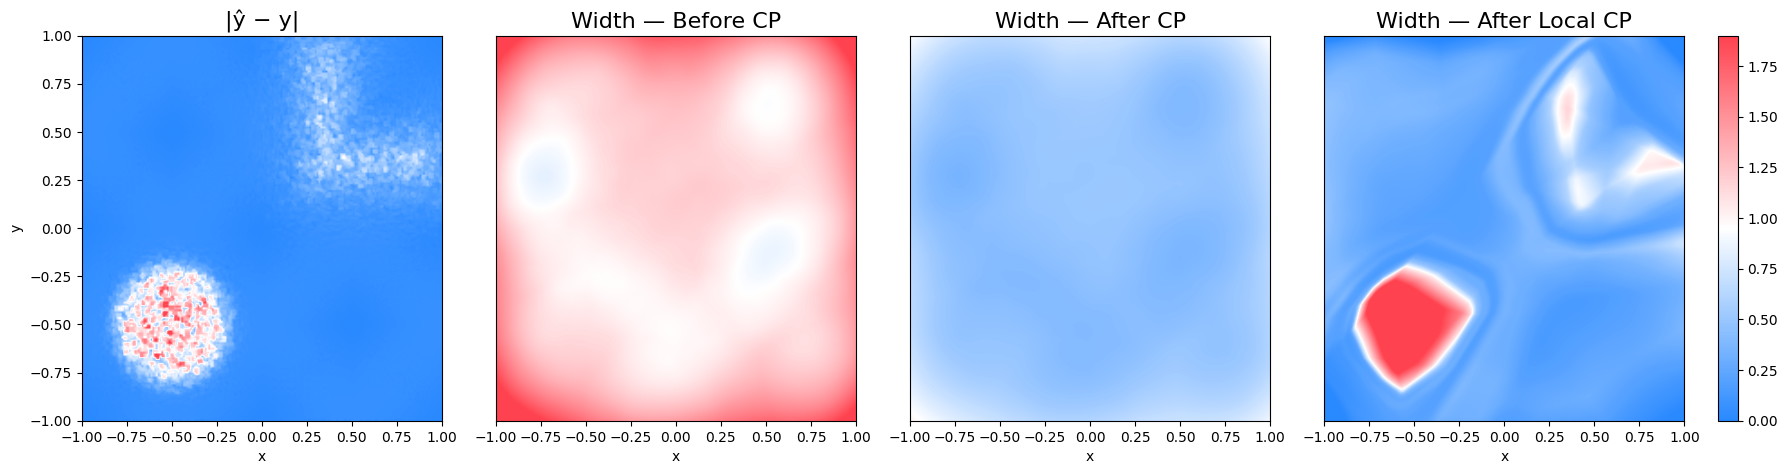

In [ ]:
plot_2D_comparison_with_coverage_error_compare(
    grid_test,
    err_est_noise, #2*(sigma*1.69),
    dist_feat_pinn_uncal_predset,
    dist_feat_pinn_cp_cal_predset,
    adp_cp_cal_predset, #<--
    true_solution, 
    vlim=(0,2.0)
)

# df1=cp_df_local_smooth
# df2=adap_df_local_smooth
# cp_df_local, #<--
# adap_df_local, #<--

# Test across the alpha grid

In [21]:
# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid_2d_ac, cp_test_uncertainties_in_noisy_region
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas




cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "idx_noisy_test":id_test,
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
cp_df_local = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
adap_df_local = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)




CP (noisy/complement) grid:   0%|          | 0/19 [00:00<?, ?it/s]

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:15<04:47, 15.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:32<04:32, 16.04s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [00:48<04:17, 16.12s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:04<04:01, 16.12s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:20<03:43, 15.99s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [01:35<03:27, 15.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [01:51<03:11, 15.95s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:07<02:55, 15.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:25<02:44, 16.41s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [02:42<02:30, 16.68s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [02:59<02:14, 16.83s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [03:17<01:59, 17.07s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [03:34<01:42, 17.08s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [03:51<01:24, 16.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [04:07<01:07, 16.84s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [04:24<00:50, 16.78s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [04:42<00:34, 17.13s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [05:00<00:17, 17.33s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [05:17<00:00, 16.72s/it]


Uncal dev:0.02475410717583838
Cal dev:0.025387089522111984


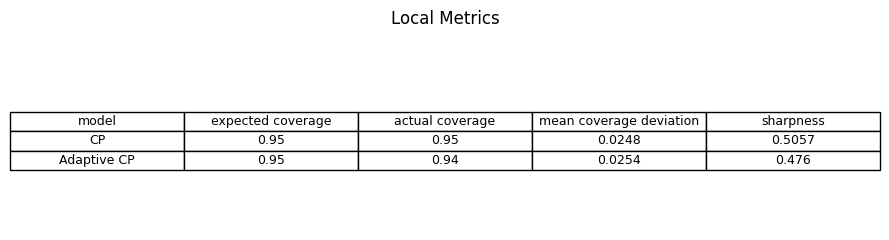

In [22]:
plot_metrics_table(None,None,None,None,cp_df_local,adap_df_local,"CP" ,"Adaptive CP", alpha_level=0.05, 
  main_title="Local Metrics"
)


In [23]:
# # Smooth region metrics

# # CP Coverage comparison
# from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
# # Conformal-prediction settings
# from utils_tools.utils_result_metrics import generating_alphas




# cp_testing_args = {
#     "uqmodel": dist_feat_pinn_cp,
#     "alphas":alphas, 
#     "X_test":X_test, "Y_test":Y_test, 
#     "X_cal":X_calibration, "Y_cal":Y_calibration, 
#     "X_train":X_train, "Y_train":Y_train, 
#     "idx_noisy_test":id_test,
#     "heuristic_u":raw_heuristic, # Change base on if the baseline cp
#     "k":k,
#     "compt_smooth":True

# }
# adapcp_testing_args = {
#     "base_md": dist_feat_pinn,
#     "alphas":alphas, 
#     "X_test":X_test, "Y_test":Y_test, 
#     "X_cal":X_calibration, "Y_cal":Y_calibration, 
#     "X_train":X_train, "Y_train":Y_train, 
#     "idx_noisy_test":id_test,
#     "heuristic_u":raw_heuristic, # Change base on if the baseline cp
#     "k":k,
#     "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
#     "conf_nn_lr":3e-5,
#     "conf_nn_epochs":20000,
#     "training_kwargs":training_kwargs,
#     "quant_seed":seed,
#     "compt_smooth":True
# }
# cp_df_local_smooth = cp_test_uncertainties_in_noisy_region(**cp_testing_args)
# adap_df_local_smooth = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:16<04:56, 16.49s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:34<05:00, 17.66s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [00:52<04:40, 17.51s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:10<04:26, 17.74s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:28<04:09, 17.79s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [01:46<03:55, 18.10s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [02:04<03:36, 18.02s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:22<03:17, 17.97s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:40<02:58, 17.85s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [02:57<02:38, 17.61s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [03:14<02:19, 17.43s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [03:31<02:01, 17.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [03:49<01:45, 17.60s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [04:07<01:27, 17.54s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [04:25<01:10, 17.74s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [04:42<00:52, 17.56s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [04:59<00:34, 17.34s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [05:16<00:17, 17.44s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [05:34<00:00, 17.60s/it]


In [24]:
# # from utils_tools.utils_result_viz import plot_metrics_table

# df1=cp_df_local_smooth
# df2=adap_df_local_smooth
# df1_name="CP" 
# df2_name="Adaptive CP"
# # save_plot(
# #     plot_metrics_table,
# #     save_dir="Adaptive_scaled_CP",
# #     prefix="adpcp_vs_cp_table_GLOBAL"
# # )(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
# #   main_title="Adaptive Conformal Prediction and Conformal Prediction Metrics")


# plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
#   main_title="Smooth Local Metrics"
# )

In [25]:
# Global Metrics

# CP Coverage comparison
from utils_extension.utils_uq_adapcp import adaptive_cp_test_uncertainties_grid, cp_test_uncertainties_in_noisy_region
from utils_tools.utils_result_metrics import cp_test_uncertainties
# Conformal-prediction settings
from utils_tools.utils_result_metrics import generating_alphas

cp_testing_args = {
    "uqmodel": dist_feat_pinn_cp,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k
}
adapcp_testing_args = {
    "base_md": dist_feat_pinn,
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":raw_heuristic, # Change base on if the baseline cp
    "k":k,
    "conf_nn_hidden_layers":(16, 32, 64, 64, 64, 32, 16),
    "conf_nn_lr":3e-5,
    "conf_nn_epochs":20000,
    "training_kwargs":training_kwargs,
    "quant_seed":seed
}
cp_df_global = cp_test_uncertainties(**cp_testing_args)
adap_df_global = adaptive_cp_test_uncertainties_grid_2d_ac(**adapcp_testing_args)

Adaptive-CP grid:   0%|          | 0/19 [00:00<?, ?it/s]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:   5%|▌         | 1/19 [00:16<05:00, 16.67s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  11%|█         | 2/19 [00:34<04:53, 17.26s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  16%|█▌        | 3/19 [00:51<04:32, 17.02s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  21%|██        | 4/19 [01:08<04:16, 17.11s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  26%|██▋       | 5/19 [01:25<04:00, 17.19s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  32%|███▏      | 6/19 [01:42<03:42, 17.14s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  37%|███▋      | 7/19 [01:59<03:22, 16.91s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  42%|████▏     | 8/19 [02:17<03:10, 17.35s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  47%|████▋     | 9/19 [02:36<02:58, 17.82s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  53%|█████▎    | 10/19 [02:55<02:42, 18.11s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  58%|█████▊    | 11/19 [03:12<02:24, 18.06s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  63%|██████▎   | 12/19 [03:30<02:05, 17.93s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  68%|██████▊   | 13/19 [03:47<01:46, 17.70s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  74%|███████▎  | 14/19 [04:05<01:28, 17.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  79%|███████▉  | 15/19 [04:22<01:10, 17.66s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  84%|████████▍ | 16/19 [04:41<00:53, 17.99s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  89%|████████▉ | 17/19 [04:58<00:35, 17.65s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid:  95%|█████████▍| 18/19 [05:16<00:17, 17.72s/it]


[🟠] Training Adaptive CP Quantile Net on TRAIN set: 300 samples


Adaptive-CP grid: 100%|██████████| 19/19 [05:33<00:00, 17.55s/it]


Uncal dev:0.026095235099395115
Cal dev:0.025666664576246626


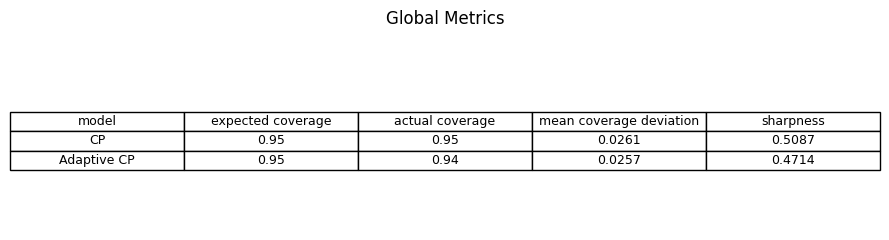

In [26]:
df1=cp_df_global
df2=adap_df_global
df1_name="CP" 
df2_name="Adaptive CP"

plot_metrics_table(None,None,None,None,df1,df2,df1_name,df2_name, alpha_level=0.05, 
  main_title="Global Metrics"
)

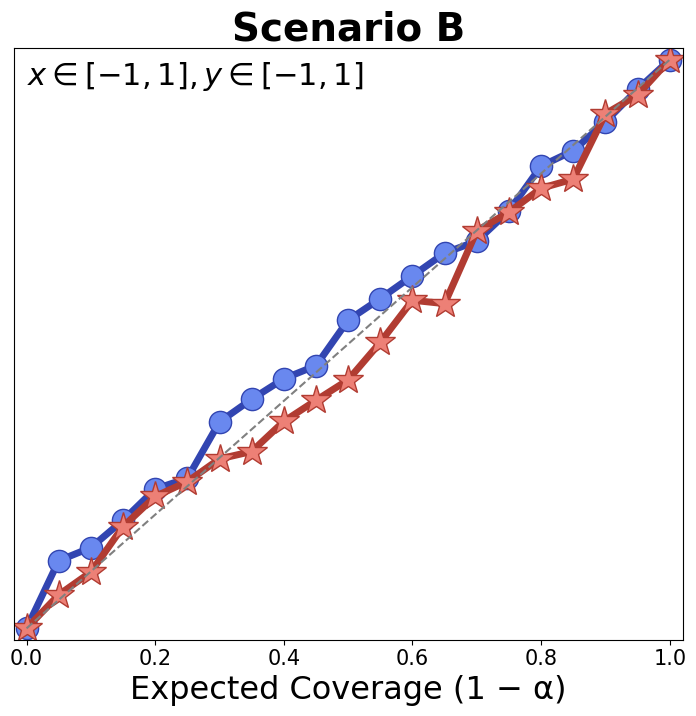

<Figure size 640x480 with 0 Axes>

In [27]:
def plot_coverage_single(
    name_dfpair,
    *,
    labels=("CP", "Local CP"),
    figsize=(7, 7.5),
    suptitle=None,
    model_title_size=28,
    float_label="$x \in \{x:c=(0,0), r=0.2\}$",
):
    """
    Plot a single coverage curve plot (no subplots).

    Parameters
    ----------
    name_dfpair : tuple
        (name, df_uncal, df_cal), where each df has 'alpha' and 'coverage' columns.
    labels : tuple(str, str)
        Legend labels for the two curves (uncal vs cal).
    figsize : tuple
        Figure size.
    suptitle : str | None
        Optional overall figure title.
    model_title_size : int
        Title fontsize for the subplot.
    float_label : tuple(str, str)
        Floating labels to place at top-left corner of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    def _prep(df):
        exp = 1.0 - df["alpha"].to_numpy()
        emp = df["coverage"].to_numpy()
        exp = np.concatenate(([0.0], exp, [1.0]))
        emp = np.concatenate(([0.0], emp, [1.0]))
        i = np.argsort(exp)
        return exp[i], emp[i]

    name, df_uncal, df_cal = name_dfpair

    plt.figure(figsize=figsize)

    exp1, emp1 = _prep(df_uncal)
    exp2, emp2 = _prep(df_cal)

    plt.plot(exp1, emp1, 'o-', color="#3245b1", markerfacecolor="#6988ef",
                     ms=16, lw=5, label=labels[1])
    plt.plot(exp2, emp2, '*-', color="#b13c32", markerfacecolor="#ed8076",
                     ms=22, lw=5, label=labels[0])
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')

    # # floating label
    # if float_label[0]:
    #     plt.text(
    #         0.02, 0.98, float_label[0],
    #         transform=plt.gca().transAxes,
    #         fontsize=22, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    # if float_label[1]:
    #     plt.text(
    #         0.02, 0.90, float_label[1],
    #         transform=plt.gca().transAxes,
    #         fontsize=16, fontweight="bold",
    #         va="top", ha="left",
    #         bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
    #     )
    plt.text(
            0.02, 0.98, float_label,
            transform=plt.gca().transAxes,
            fontsize=22, fontweight="bold",
            va="top", ha="left",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.xlabel("Expected Coverage (1 − α)", fontsize=23)
    # plt.ylabel("Empirical Coverage", fontsize=18)
    plt.title(name, fontsize=model_title_size, fontweight="bold")
    plt.margins(x=0.02, y=0.02)
    plt.yticks([])
    # plt.legend(loc="lower right", fontsize=14, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.tick_params(axis='both', labelsize=15)
    return plt


pairs = ("Scenario B", cp_df_global,    adap_df_global)


plot_coverage_single(
    pairs,
    float_label="$x \in [-1, 1], y \in [-1, 1]$"
)
plt.show()

save_plot(
    plot_coverage_single,
    save_dir="Local_CP_2D",
    prefix="cov_ol"
)(
    pairs,
    float_label="$x \in [-1, 1], y \in [-1, 1]$"
)



<module 'matplotlib.pyplot' from '/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/matplotlib/pyplot.py'>

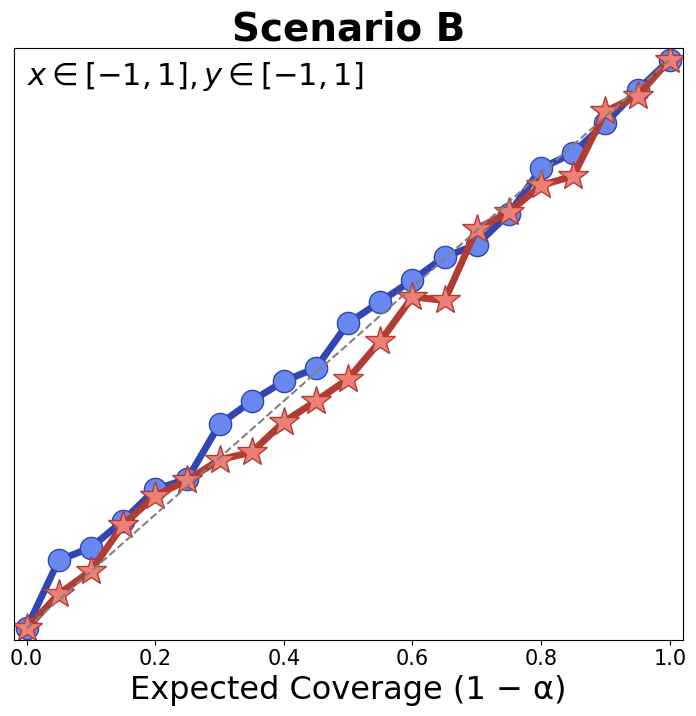

In [28]:
pairs = ("Scenario B", cp_df_local,    adap_df_local)


plot_coverage_single(
    pairs,
    float_label=r"$x \in [-1, 1], y \in [-1, 1]$"
)